In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
from pathlib import Path

# Define the path you want to check
path = Path('/kaggle/input/lfw-dataset')

# List all files and directories
for item in path.iterdir():
    print(item)


/kaggle/input/lfw-dataset/mismatchpairsDevTrain.csv
/kaggle/input/lfw-dataset/matchpairsDevTest.csv
/kaggle/input/lfw-dataset/pairs.csv
/kaggle/input/lfw-dataset/lfw_allnames.csv
/kaggle/input/lfw-dataset/peopleDevTest.csv
/kaggle/input/lfw-dataset/lfw-deepfunneled
/kaggle/input/lfw-dataset/people.csv
/kaggle/input/lfw-dataset/peopleDevTrain.csv
/kaggle/input/lfw-dataset/mismatchpairsDevTest.csv
/kaggle/input/lfw-dataset/lfw_readme.csv
/kaggle/input/lfw-dataset/matchpairsDevTrain.csv


In [ ]:
import os
import csv
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def read_pairs(match_csv_path, mismatch_csv_path):
    pairs = []

    # Positive pairs (matchpairs CSV): 3 columns (name, img1, img2), label=1
    with open(match_csv_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # skip header
        for row in reader:
            if len(row) < 3:
                continue
            person, img1, img2 = row[0], row[1], row[2]
            pairs.append([person, img1, person, img2, 1])

    # Negative pairs (mismatchpairs CSV): 4 columns (name1, img1, name2, img2), label=0
    with open(mismatch_csv_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) < 4:
                continue
            person1, img1, person2, img2 = row[0], row[1], row[2], row[3]
            pairs.append([person1, img1, person2, img2, 0])

    print(f"Loaded {len(pairs)} total pairs: positive={sum(1 for x in pairs if x[4]==1)}, negative={sum(1 for x in pairs if x[4]==0)}")
    return pairs

In [ ]:
class LFWPairsDataset(Dataset):
    def __init__(self, image_root, match_csv, mismatch_csv, transform=None):
        self.image_root = image_root
        self.pairs = read_pairs(match_csv, mismatch_csv)
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        p1, i1, p2, i2, label = self.pairs[idx]

        fname1 = f"{p1}_{int(i1):04d}.jpg"
        fname2 = f"{p2}_{int(i2):04d}.jpg"

        path1 = os.path.join(self.image_root, p1, fname1)
        path2 = os.path.join(self.image_root, p2, fname2)

        try:
            img1 = Image.open(path1).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {path1}")

        try:
            img2 = Image.open(path2).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {path2}")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label



In [ ]:
class LFWTripletDataset(Dataset):
    def __init__(self, pairs_dataset):
        self.pairs_dataset = pairs_dataset
        self.positive_pairs = [p for p in pairs_dataset.pairs if p[4] == 1]
        self.negative_pairs = [p for p in pairs_dataset.pairs if p[4] == 0]

    def __len__(self):
        return len(self.positive_pairs)

    def load_image(self, person, idx):
        fname = f"{person}_{int(idx):04d}.jpg"
        path = os.path.join(self.pairs_dataset.image_root, person, fname)
        img = Image.open(path).convert('RGB')
        if self.pairs_dataset.transform:
            img = self.pairs_dataset.transform(img)
        return img

    def __getitem__(self, idx):
        p = self.positive_pairs[idx]
        anchor = self.load_image(p[0], p[1])
        positive = self.load_image(p[2], p[3])
        neg_p = random.choice(self.negative_pairs)
        negative = self.load_image(neg_p[2], neg_p[3])
        return anchor, positive, negative



In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

IMAGE_ROOT = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
MATCH_TRAIN_CSV = '/kaggle/input/lfw-dataset/matchpairsDevTrain.csv'
MISMATCH_TRAIN_CSV = '/kaggle/input/lfw-dataset/mismatchpairsDevTrain.csv'
MATCH_TEST_CSV = '/kaggle/input/lfw-dataset/matchpairsDevTest.csv'
MISMATCH_TEST_CSV = '/kaggle/input/lfw-dataset/mismatchpairsDevTest.csv'

# dataloader
train_dataset = LFWPairsDataset(IMAGE_ROOT, MATCH_TRAIN_CSV, MISMATCH_TRAIN_CSV, transform=transform)
test_dataset = LFWPairsDataset(IMAGE_ROOT, MATCH_TEST_CSV, MISMATCH_TEST_CSV, transform=transform)
train_loader_bce_contrastive = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_bce_contrastive = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_triplet_dataset = LFWTripletDataset(train_dataset)
train_loader_triplet = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)


Loaded 2200 total pairs: positive=1100, negative=1100
Loaded 1000 total pairs: positive=500, negative=500


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(3, 32, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5), nn.ReLU(), nn.MaxPool2d(2)
        )
        # (128 -> 124) -> pool(62)
        # (62 -> 58) -> pool(29)
        self.fc = nn.Linear(64 * 29 * 29, 128)

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)


In [ ]:
bce_loss_fn = nn.BCEWithLogitsLoss()
margin = 1.0


def contrastive_loss(out1, out2, label):
    dist = F.pairwise_distance(out1, out2)
    loss_pos = label * dist.pow(2)
    loss_neg = (1 - label) * F.relu(margin - dist).pow(2)
    return (loss_pos + loss_neg).mean()


def triplet_loss(anchor, positive, negative):
    dist_pos = F.pairwise_distance(anchor, positive)
    dist_neg = F.pairwise_distance(anchor, negative)
    return F.relu(dist_pos - dist_neg + margin).mean()

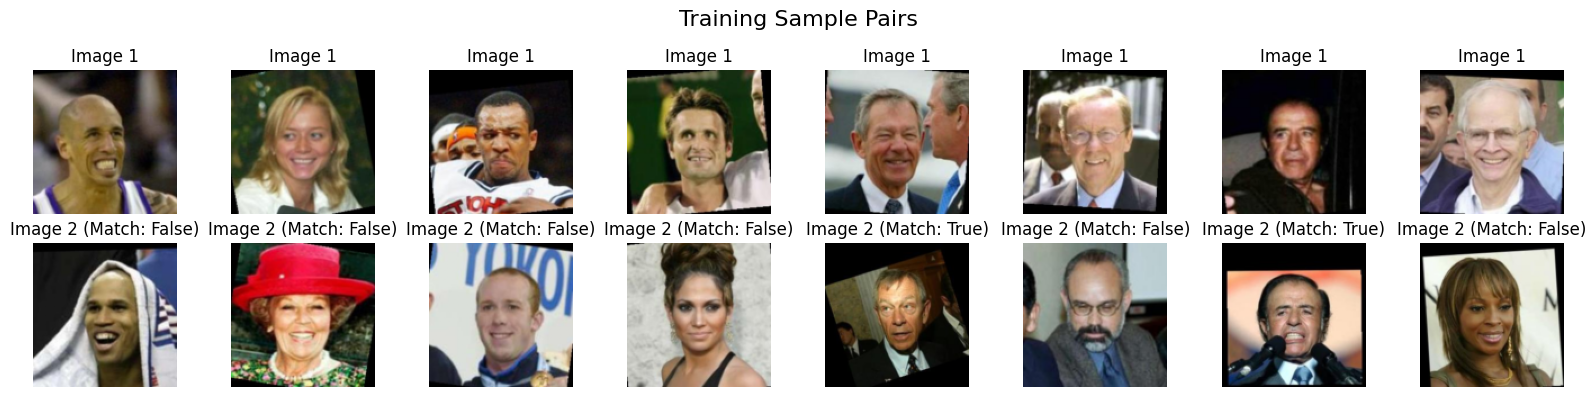

In [ ]:
def plot_sample_pairs(dataset, num_samples=8, title="Sample Image Pairs"):
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)

    # Get random samples
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        img1, img2, label = dataset[idx]

        # Convert tensor to numpy for plotting
        img1_np = img1.permute(1, 2, 0).numpy()
        img2_np = img2.permute(1, 2, 0).numpy()

        # Clip values to [0, 1] for display
        img1_np = np.clip(img1_np, 0, 1)
        img2_np = np.clip(img2_np, 0, 1)

        axes[0, i].imshow(img1_np)
        axes[0, i].set_title(f"Image 1")
        axes[0, i].axis('off')

        axes[1, i].imshow(img2_np)
        axes[1, i].set_title(f"Image 2 (Match: {bool(label.item())})")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_pairs(train_dataset, title="Training Sample Pairs")

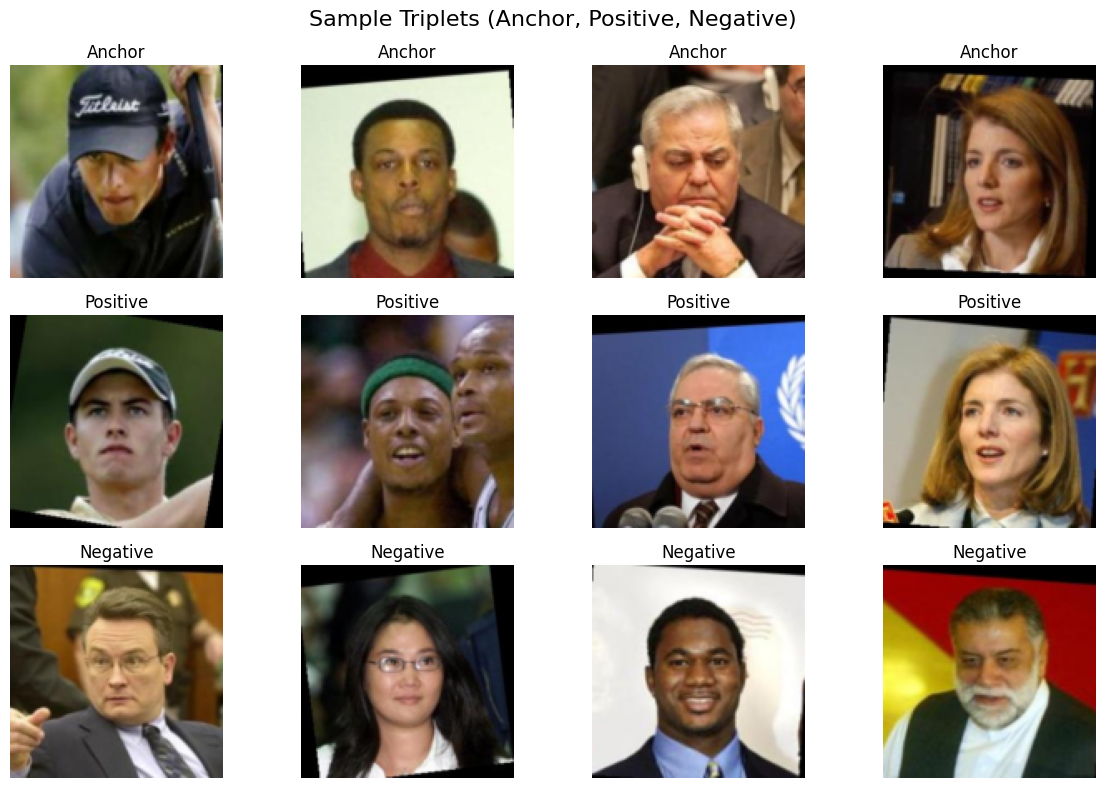

In [ ]:
def plot_triplet_samples(triplet_dataset, num_samples=4):
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))
    fig.suptitle("Sample Triplets (Anchor, Positive, Negative)", fontsize=16)

    indices = random.sample(range(len(triplet_dataset)), num_samples)

    for i, idx in enumerate(indices):
        anchor, positive, negative = triplet_dataset[idx]

        # Convert tensors to numpy
        anchor_np = anchor.permute(1, 2, 0).numpy()
        positive_np = positive.permute(1, 2, 0).numpy()
        negative_np = negative.permute(1, 2, 0).numpy()

        # Clip values
        anchor_np = np.clip(anchor_np, 0, 1)
        positive_np = np.clip(positive_np, 0, 1)
        negative_np = np.clip(negative_np, 0, 1)

        axes[0, i].imshow(anchor_np)
        axes[0, i].set_title("Anchor")
        axes[0, i].axis('off')

        axes[1, i].imshow(positive_np)
        axes[1, i].set_title("Positive")
        axes[1, i].axis('off')

        axes[2, i].imshow(negative_np)
        axes[2, i].set_title("Negative")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_triplet_samples(train_triplet_dataset)

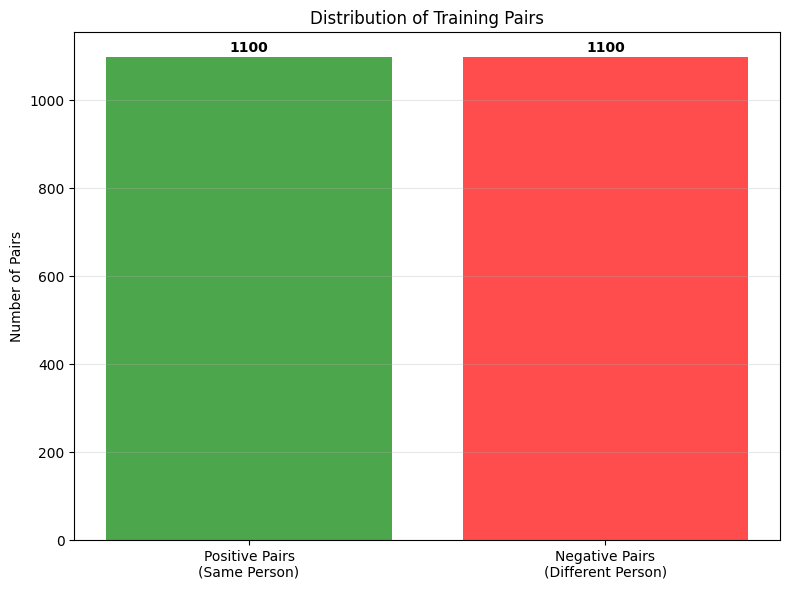

In [ ]:
def plot_data_distribution(dataset):
    labels = [pair[4] for pair in dataset.pairs]
    positive_count = sum(labels)
    negative_count = len(labels) - positive_count

    plt.figure(figsize=(8, 6))
    plt.bar(['Positive Pairs\n(Same Person)', 'Negative Pairs\n(Different Person)'],
            [positive_count, negative_count],
            color=['green', 'red'], alpha=0.7)
    plt.title('Distribution of Training Pairs')
    plt.ylabel('Number of Pairs')
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    plt.text(0, positive_count + 10, str(positive_count), ha='center', fontweight='bold')
    plt.text(1, negative_count + 10, str(negative_count), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
plot_data_distribution(train_dataset)

In [ ]:
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_similarities = []
    all_labels = []

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1, x2 = x1.to(device), x2.to(device)
            emb1 = model(x1)
            emb2 = model(x2)
            similarities = F.cosine_similarity(emb1, emb2).cpu().numpy()

            all_similarities.extend(similarities)
            all_labels.extend(labels.numpy())

    return np.array(all_similarities), np.array(all_labels)

In [ ]:

def plot_similarity_distribution(similarities, labels, model_name="Model"):
    pos_similarities = similarities[labels == 1]
    neg_similarities = similarities[labels == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(pos_similarities, bins=30, alpha=0.7, label='Positive Pairs (Same Person)',
             color='green', density=True)
    plt.hist(neg_similarities, bins=30, alpha=0.7, label='Negative Pairs (Different Person)',
             color='red', density=True)

    plt.xlabel('Cosine Similarity Score')
    plt.ylabel('Density')
    plt.title(f'{model_name}: Similarity Score Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:

def roc_calculate(similarities, labels, model_name="Model"):
    fpr, tpr, _ = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)

    return roc_auc


def train_bce(model, loader, optimizer, epochs=25):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, y in loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            emb1 = model(x1)
            emb2 = model(x2)
            sim = F.cosine_similarity(emb1, emb2)
            loss = bce_loss_fn(sim, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)
        print(f"[BCE] Epoch {epoch +1} loss: {avg:.4f}")
        losses.append(avg)
    return losses


def train_contrastive(model, loader, optimizer, epochs=25):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, y in loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            emb1 = model(x1)
            emb2 = model(x2)
            loss = contrastive_loss(emb1, emb2, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)
        print(f"[Contrastive] Epoch {epoch +1} loss: {avg:.4f}")
        losses.append(avg)
    return losses


def train_triplet(model, loader, optimizer, epochs=25):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for a, p, n in loader:
            a = a.to(device)
            p = p.to(device)
            n = n.to(device)
            optimizer.zero_grad()
            emb_a = model(a)
            emb_p = model(p)
            emb_n = model(n)
            loss = triplet_loss(emb_a, emb_p, emb_n)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(loader)
        print(f"[Triplet] Epoch {epoch +1} loss: {avg:.4f}")
        losses.append(avg)
    return losses

model_bce = EmbeddingNet().to(device)
opt_bce = torch.optim.Adam(model_bce.parameters(), lr=1e-3)

model_contrastive = EmbeddingNet().to(device)
opt_contrastive = torch.optim.Adam(model_contrastive.parameters(), lr=1e-3)

model_triplet = EmbeddingNet().to(device)
opt_triplet = torch.optim.Adam(model_triplet.parameters(), lr=1e-3)

print("Training with BCE Loss")
losses_bce = train_bce(model_bce, train_loader_bce_contrastive, opt_bce, epochs=25)

print("\nTraining with Contrastive Loss")
losses_contrastive = train_contrastive(model_contrastive, train_loader_bce_contrastive, opt_contrastive, epochs=25)

print("\nTraining with Triplet Loss")
losses_triplet = train_triplet(model_triplet, train_loader_triplet, opt_triplet, epochs=25)

Training with BCE Loss
[BCE] Epoch 1 loss: 0.7031
[BCE] Epoch 2 loss: 0.6468
[BCE] Epoch 3 loss: 0.6319
[BCE] Epoch 4 loss: 0.6176
[BCE] Epoch 5 loss: 0.6038
[BCE] Epoch 6 loss: 0.5842
[BCE] Epoch 7 loss: 0.5587
[BCE] Epoch 8 loss: 0.5268
[BCE] Epoch 9 loss: 0.4992
[BCE] Epoch 10 loss: 0.4739
[BCE] Epoch 11 loss: 0.4531
[BCE] Epoch 12 loss: 0.4307
[BCE] Epoch 13 loss: 0.4130
[BCE] Epoch 14 loss: 0.3973
[BCE] Epoch 15 loss: 0.3849
[BCE] Epoch 16 loss: 0.3752
[BCE] Epoch 17 loss: 0.3643
[BCE] Epoch 18 loss: 0.3557
[BCE] Epoch 19 loss: 0.3497
[BCE] Epoch 20 loss: 0.3434
[BCE] Epoch 21 loss: 0.3386
[BCE] Epoch 22 loss: 0.3348
[BCE] Epoch 23 loss: 0.3324
[BCE] Epoch 24 loss: 0.3292
[BCE] Epoch 25 loss: 0.3266

Training with Contrastive Loss
[Contrastive] Epoch 1 loss: 0.2698
[Contrastive] Epoch 2 loss: 0.2197
[Contrastive] Epoch 3 loss: 0.2058
[Contrastive] Epoch 4 loss: 0.1917
[Contrastive] Epoch 5 loss: 0.1686
[Contrastive] Epoch 6 loss: 0.1437
[Contrastive] Epoch 7 loss: 0.1218
[Contrast

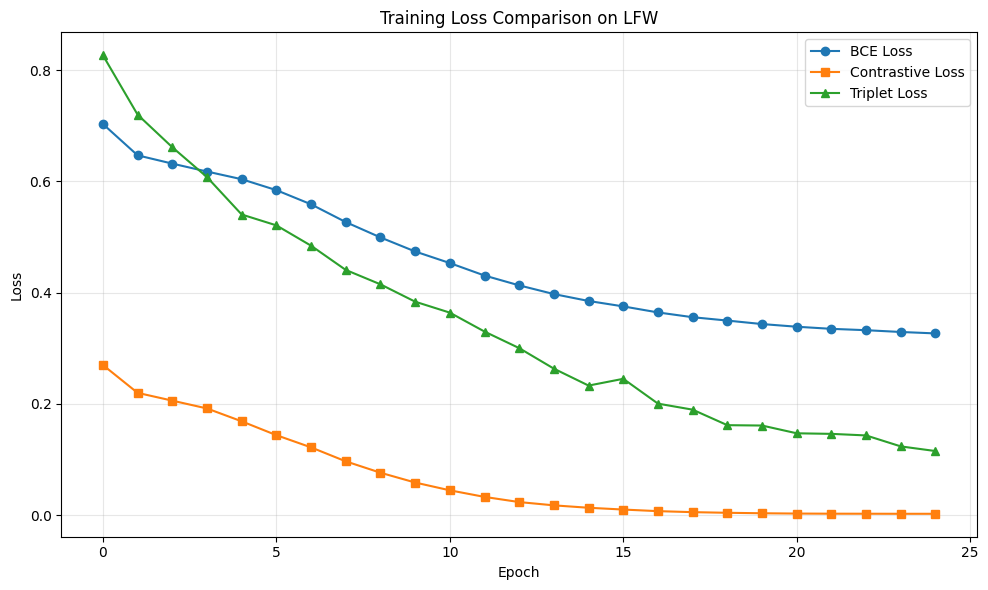

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(losses_bce, label='BCE Loss', marker='o')
plt.plot(losses_contrastive, label='Contrastive Loss', marker='s')
plt.plot(losses_triplet, label='Triplet Loss', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison on LFW')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

# Evaluate BCE model
similarities_bce, labels_test = evaluate_model(model_bce, test_loader_bce_contrastive, "BCE")
auc_bce = roc_calculate(similarities_bce, labels_test, "BCE Model")

# Evaluate Contrastive model
similarities_cont, _ = evaluate_model(model_contrastive, test_loader_bce_contrastive, "Contrastive")
auc_cont = roc_calculate(similarities_cont, labels_test, "Contrastive Model")

# Evaluate Triplet model
similarities_trip, _ = evaluate_model(model_triplet, test_loader_bce_contrastive, "Triplet")
auc_trip = roc_calculate(similarities_trip, labels_test, "Triplet Model")


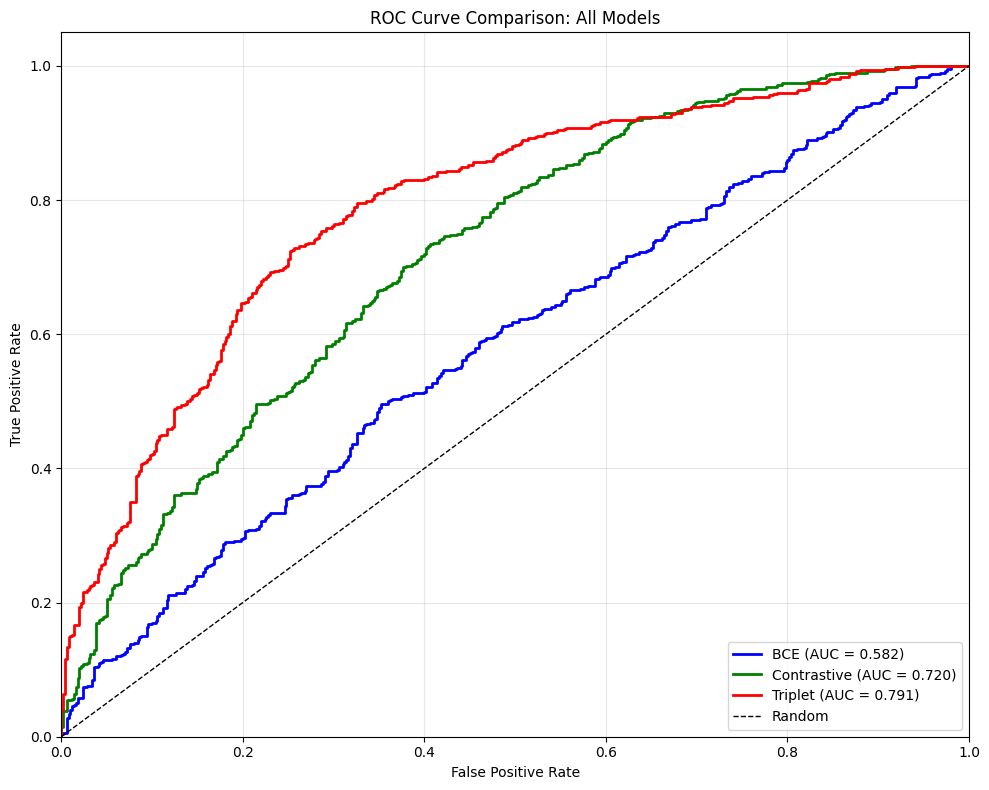

In [ ]:

plt.figure(figsize=(10, 8))
fpr_bce, tpr_bce, _ = roc_curve(labels_test, similarities_bce)
fpr_cont, tpr_cont, _ = roc_curve(labels_test, similarities_cont)
fpr_trip, tpr_trip, _ = roc_curve(labels_test, similarities_trip)

plt.plot(fpr_bce, tpr_bce, color='blue', lw=2, label=f'BCE (AUC = {auc_bce:.3f})')
plt.plot(fpr_cont, tpr_cont, color='green', lw=2, label=f'Contrastive (AUC = {auc_cont:.3f})')
plt.plot(fpr_trip, tpr_trip, color='red', lw=2, label=f'Triplet (AUC = {auc_trip:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

best_model = model_bce if auc_bce >= max(auc_cont, auc_trip) else (model_contrastive if auc_cont >= auc_trip else model_triplet)
best_name = "BCE" if auc_bce >= max(auc_cont, auc_trip) else ("Contrastive" if auc_cont >= auc_trip else "Triplet")

print(f"\nPlotting embedding space for best model: {best_name}")


Plotting embedding space for best model: Triplet


In [ ]:

print(f"BCE Model - AUC: {auc_bce:.3f}")
print(f"Contrastive Model - AUC: {auc_cont:.3f}")
print(f"Triplet Model - AUC: {auc_trip:.3f}")
print(f"Best Model: {best_name} with AUC: {max(auc_bce, auc_cont, auc_trip):.3f}")

BCE Model - AUC: 0.590
Contrastive Model - AUC: 0.752
Triplet Model - AUC: 0.771
Best Model: Triplet with AUC: 0.771
